In [1]:
import streamlit as st
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import glob
import os

In [2]:
%matplotlib inline

In [16]:
# Load all CSV files in the current directory
csv_files = glob.glob(os.path.join(os.getcwd(), "data/TogglTrack_Report_Detailed_report_*.csv"))
dfs = []
for file in csv_files:
    print("reading file:", file)
    df = pd.read_csv(file)
    dfs.append(df)
if not dfs:
    st.warning("Aucun fichier CSV trouvé dans le dossier.")
    st.stop()

# Concatenate all data
data = pd.concat(dfs, ignore_index=True)
print(data.shape)
data.head()

reading file: c:\Users\aurel\Documents\Pro\ClimatMedias\Admin\Suivi_temps\data\TogglTrack_Report_Detailed_report_(from_01_11_2025_to_30_11_2025).csv
reading file: c:\Users\aurel\Documents\Pro\ClimatMedias\Admin\Suivi_temps\data\TogglTrack_Report_Detailed_report__from_01_04_2025_to_30_04_2025_.csv
reading file: c:\Users\aurel\Documents\Pro\ClimatMedias\Admin\Suivi_temps\data\TogglTrack_Report_Detailed_report__from_01_05_2025_to_31_05_2025_.csv
reading file: c:\Users\aurel\Documents\Pro\ClimatMedias\Admin\Suivi_temps\data\TogglTrack_Report_Detailed_report__from_01_06_2025_to_30_06_2025_.csv
reading file: c:\Users\aurel\Documents\Pro\ClimatMedias\Admin\Suivi_temps\data\TogglTrack_Report_Detailed_report__from_01_07_2025_to_31_07_2025_.csv
reading file: c:\Users\aurel\Documents\Pro\ClimatMedias\Admin\Suivi_temps\data\TogglTrack_Report_Detailed_report__from_01_08_2025_to_31_08_2025_.csv
reading file: c:\Users\aurel\Documents\Pro\ClimatMedias\Admin\Suivi_temps\data\TogglTrack_Report_Detailed_

,Description,Duration,Project,Tags,Start date,Stop date
0,Comité Expert,2:34:34,Méthodo Presse,-,2025-11-25,2025-11-25
1,Rédaction demande Subvention Paris,7:05:43,Financement,-,2025-11-25,2025-11-25
2,AAP Ville de Paris,2:39:26,Financement,-,2025-11-24,2025-11-24
3,Préparation CE,3:10:00,Méthodo Presse,-,2025-11-24,2025-11-24
4,Point Jules Brion,1:12:44,Méthodo Presse,-,2025-11-21,2025-11-21


In [4]:
data["Start date"].min()

'2025-04-10'

In [5]:
# Résumé
data.describe()

,Description,Duration,Project,Tags,Start date,Stop date
count,273,273,273,273,273,273
unique,206,252,18,1,97,96
top,Point Hebdo Presse Ecrite,7:00:00,Méthodo Presse,-,2025-07-18,2025-04-25
freq,8,8,155,273,9,8


In [6]:
def duration_to_hours(duration_str):
    """Convertit une durée 'H:MM:SS' en heures décimales."""
    h, m, s = map(int, duration_str.split(':'))
    return h + m/60 + s/3600

In [7]:
# Parse date column
data['date'] = pd.to_datetime(data['Start date'], format='%Y-%m-%d', errors='coerce')
data['time'] = data['Duration'].apply(duration_to_hours)
data['month'] = data['date'].dt.to_period('M').astype(str)

In [8]:
# Ajout colonne "heures_a_faire" par mois
heures_a_faire = {}
for m in data['month'].unique():
    if m == "2025-04":
        heures_a_faire[m] = 30.34
    else:
        heures_a_faire[m] = 60.67
data['heures_a_faire'] = data['month'].map(heures_a_faire)

# Calcul du temps total par mois et du temps dépassé
bilan_mensuel = data.groupby('month').agg(
    heures_realisees=('time', 'sum'),
    heures_a_faire=('heures_a_faire', 'first')
).reset_index()
bilan_mensuel['depassement'] = bilan_mensuel['heures_realisees'] - bilan_mensuel['heures_a_faire']
bilan_mensuel['cumul'] = bilan_mensuel['depassement'].cumsum()

# Calcul du bilan global
bilan_global = {
    "heures_realisees": bilan_mensuel['heures_realisees'].sum(),
    "heures_a_faire": bilan_mensuel['heures_a_faire'].sum(),
    "depassement_total": bilan_mensuel['depassement'].sum(),
}


In [9]:
# Si le fichier existe, on le supprime d'abord
if os.path.exists("bilan_global.xlsx"):
    os.remove("bilan_global.xlsx")

# Ensuite on crée un nouveau fichier avec les deux feuilles
with pd.ExcelWriter("bilan_global.xlsx", engine='openpyxl') as writer:
    data.to_excel(writer, sheet_name="Données", index=False)
    bilan_mensuel.to_excel(writer, sheet_name="Bilan_mensuel", index=False)


In [10]:
# Affichage du bilan global dans le notebook
print("Bilan global :", bilan_global)

Bilan global : {'heures_realisees': np.float64(477.64666666666665), 'heures_a_faire': np.float64(455.03000000000003), 'depassement_total': np.float64(22.61666666666665)}


In [11]:
# Check columns
data.head()

,Description,Duration,Project,Tags,Start date,Stop date,date,time,month,heures_a_faire
0,Comité Expert,2:34:34,Méthodo Presse,-,2025-11-25,2025-11-25,2025-11-25,2.576111,2025-11,60.67
1,Rédaction demande Subvention Paris,7:05:43,Financement,-,2025-11-25,2025-11-25,2025-11-25,7.095278,2025-11,60.67
2,AAP Ville de Paris,2:39:26,Financement,-,2025-11-24,2025-11-24,2025-11-24,2.657222,2025-11,60.67
3,Préparation CE,3:10:00,Méthodo Presse,-,2025-11-24,2025-11-24,2025-11-24,3.166667,2025-11,60.67
4,Point Jules Brion,1:12:44,Méthodo Presse,-,2025-11-21,2025-11-21,2025-11-21,1.212222,2025-11,60.67


In [12]:
data.describe()

,date,time,heures_a_faire
count,273,273.000000,273.000000
mean,2025-08-07 19:25:42.857142784,1.749621,57.559231
min,2025-04-10 00:00:00,0.021944,30.340000
25%,2025-06-02 00:00:00,0.500000,60.670000
50%,2025-08-18 00:00:00,1.212222,60.670000
75%,2025-10-14 00:00:00,2.291944,60.670000
max,2025-11-25 00:00:00,12.407500,60.670000
std,NaN,1.789335,9.218679


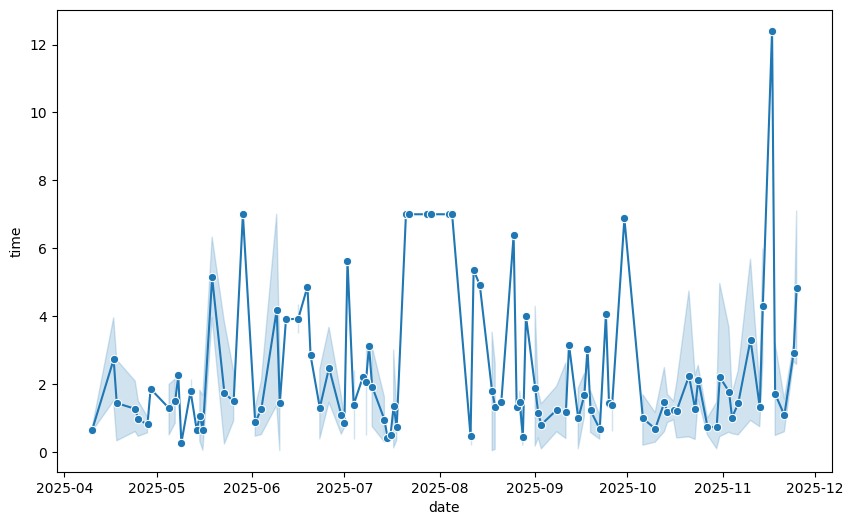

In [13]:
# Plot time
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='date', y='time', marker='o')
plt.show()

In [14]:
# Time per month
data['month'] = data['date'].dt.to_period('M').astype(str)
time_per_month = data.groupby('month')['time'].sum().reset_index()
time_per_month

,month,time
0,2025-04,33.174167
1,2025-05,60.987500
2,2025-06,64.049722
3,2025-07,67.886389
4,2025-08,48.881389
5,2025-09,62.206111
6,2025-10,60.335000
7,2025-11,80.126389


2025-12-02 09:50:15.499 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 09:50:16.679 
  command:

    streamlit run c:\ProgramData\Anaconda3\envs\climat_medias_admin\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-02 09:50:16.680 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 09:50:16.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 09:50:16.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 09:50:16.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 09:50:16.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 09:50:16.99

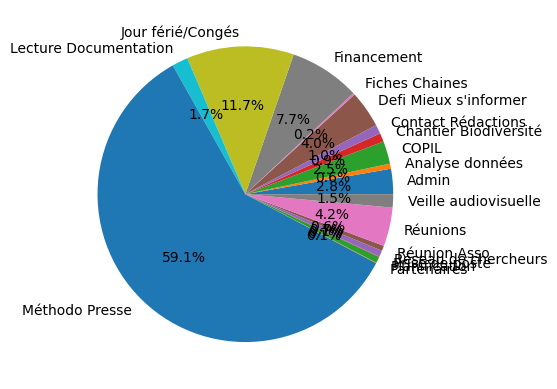

In [15]:
# Time per project ratio
time_per_project = data.groupby('Project')['time'].sum()
st.subheader("Répartition du temps par projet")
fig, ax = plt.subplots()
time_per_project.plot.pie(autopct='%1.1f%%', ylabel='', ax=ax)
st.pyplot(fig)

# Section pour définir les types de projets
st.subheader("Catégorisation des projets")

all_projects = sorted(data['Project'].unique())
ome_projects = st.multiselect("Sélectionnez les projets OME :", all_projects)
cm_projects = st.multiselect("Sélectionnez les projets Climat Médias :", [p for p in all_projects if p not in ome_projects])

# Attribution du type de projet
def get_type(proj):
    if proj in ome_projects:
        return "OME"
    elif proj in cm_projects:
        return "CM"
    else:
        return "Autre"

data['type_projet'] = data['Project'].apply(get_type)

# Heures mensuelles par type de projet
monthly_type = data.groupby([data['month'], 'type_projet'])['time'].sum().unstack(fill_value=0)
st.subheader("Heures mensuelles par type de projet")
st.bar_chart(monthly_type)

# Ratio OME/CM par mois
st.subheader("Ratio OME/CM par mois")
if "OME" in monthly_type.columns and "CM" in monthly_type.columns:
    ratio_monthly = (monthly_type["OME"] / (monthly_type["CM"] + 1e-9)).rename("OME/CM")
    st.line_chart(ratio_monthly)
else:
    st.info("Sélectionnez au moins un projet OME et un projet CM pour voir le ratio.")

# Ratio OME/CM total
total_ome = data.loc[data['type_projet'] == "OME", 'time'].sum()
total_cm = data.loc[data['type_projet'] == "CM", 'time'].sum()
st.subheader("Ratio OME/CM total")
if total_cm > 0:
    st.metric("OME/CM total", f"{total_ome / total_cm:.2f}")
else:
    st.info("Pas d'heures pour les projets CM.")


# Show raw data if needed
if st.checkbox("Afficher les données brutes"):
    st.write(data)                                   